### Code that obtains stellar, gas and residual velocity maps alongside resiudal velocity value for a set of galaxies

Import all necessary libraries, including extra code needed to run smoothly

In [1]:
import numpy as np
import marvin
from marvin import config
import pandas as pd
from marvin.tools import Maps
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import median_filter

# Set Marvin release to DR17 and avoid API error
config.setDR('DR17')
config.switchSasUrl(sasmode='mirror')

[INFO]: No release version set. Setting default to DR17


Define function to calculate the absolute difference stellar and gas velocity

In [11]:
def calculate_delta_v_star_g(stellar_vel, gas_vel):
    """
    
    Calculates the absolute difference in the stellar and gas velocity at each point in a maps as follows:
    
    |Δ_v-g| = |stellar_vel(x, y) - gas_vel(x, y)|
    
    Also calculates the sum of the residual map at each point to give a value to quantify the offset 
    between the gas and stellar velocity
    
    INPUT
    stellar_vel: stellar velocity map values
    gas_vel: gas velocity map values
    
    OUTPUT
    dvsg_map: absolute map of difference between stellar and gas velocity
    dvsg_sum: sum of dvsg at each point on the dvsg map
    dvsg_N_non_zero: the number of points in the dvsg array that are non-zero
    """
    
    # Create residual map
    dvsg_map = np.abs(stellar_vel - gas_vel)
    
    # Calculate summed residual value
    dvsg_sum = np.sum(dvsg_map)
    
    # Find number of non-zero spaxels
    dvsg_non_zero = np.nonzero(dvsg_map)
    dvsg_n_non_zero = np.shape(dvsg_non_zero)[1]
    
    return dvsg_map, dvsg_sum, dvsg_n_non_zero

def normalise_velocity(vel_array):
    
    # Separate into positive and negative components of velocity
    vel_pos = np.maximum(0, vel_array)
    vel_neg = np.minimum(0, vel_array)
    
    # Normalise by maximum value
    vel_pos_norm = vel_pos / np.max(vel_pos)
    vel_neg_norm = vel_neg / np.abs(np.min(vel_neg))

    vel_norm = vel_pos_norm + vel_neg_norm
    
    return vel_norm

Access .txt file containing set of 100 selected MaNGA candidates that satisfy selection criteria

In [3]:
candidates = np.loadtxt("100_galaxy_plateifu_list.txt", dtype='int')  # Access as integer

Open DRPall fits file

In [4]:
# Open data
drpall = fits.open('/Users/Jonah/sas/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits')
tbdata = drpall[1].data

### Demonstration of problem with using ulater median filter to reduce noise

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead. (MatplotlibDeprecationWarning)
[WARNING]: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead. (MatplotlibDeprecationWarning)


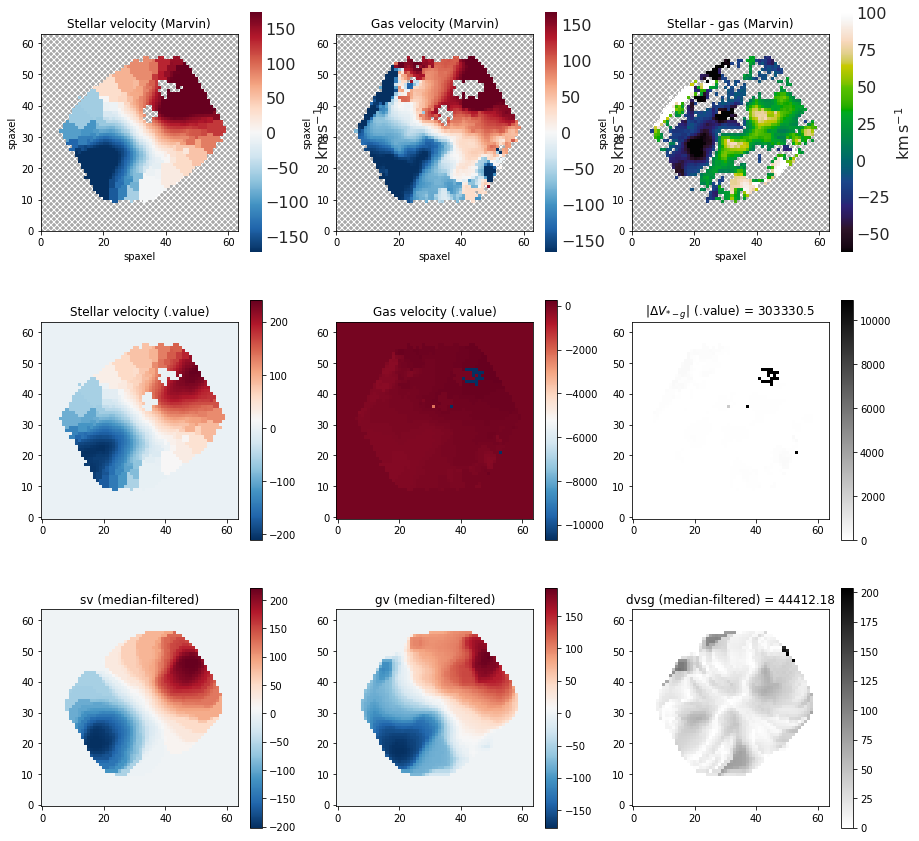

In [6]:
maps = Maps('8727-9101')

# Create figure
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Stellar and gas velocity from Marvin
sv = maps.stellar_vel
gv = maps.emline_gvel_ha_6554
dvsg = sv - gv

# Data obtained from .value
sv_vals = sv.value
gv_vals = gv.value
dvsg_out = calculate_delta_v_star_g(sv_vals, gv_vals)
dvsg_map = dvsg_out[0]
dvsg_sum = dvsg_out[1]
dvsg_N_non_zero = dvsg_out[2]

# Median filtered values
sv_mf = median_filter(input=sv_vals, size=10)  # Test 10x10 kernel as in Géron 2023
gv_mf = median_filter(input=gv_vals, size=10)
dvsg_mf_out = calculate_delta_v_star_g(sv_mf, gv_mf)
dvsg_mf_map = dvsg_mf_out[0]
dvsg_mf_sum = dvsg_mf_out[1]
dvsg_mf_n_non_zero = dvsg_mf_out[2]

num_xy = np.shape(sv_vals)[0]
x = np.arange(num_xy)
y = x

# Plot Marvin data
sv.plot(fig=fig, ax=ax[0, 0], title="Stellar velocity (Marvin)")
gv.plot(fig=fig, ax=ax[0, 1], title="Gas velocity (Marvin)")
dvsg.plot(fig=fig, ax=ax[0, 2], title="Stellar - gas (Marvin)")

# Plot .value data
sv_pcolormesh = ax[1, 0].pcolormesh(x, y, sv_vals, cmap="RdBu_r")
fig.colorbar(sv_pcolormesh)
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title("Stellar velocity (.value)")
gv_pcolormesh = ax[1, 1].pcolormesh(x, y, gv_vals, cmap="RdBu_r")
fig.colorbar(gv_pcolormesh)
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title("Gas velocity (.value)")
dvsg_pcolormesh = ax[1, 2].pcolormesh(x, y, dvsg_map, cmap=cm.binary)
fig.colorbar(dvsg_pcolormesh)
ax[1, 2].set_aspect('equal')
ax[1, 2].set_title(r"$|\Delta V_{*-g}|$ (.value) = " + str(dvsg_sum))

# Plot median-filtered data
sv_mf_pcolormesh = ax[2, 0].pcolormesh(x, y, sv_mf, cmap="RdBu_r")
fig.colorbar(sv_mf_pcolormesh)
ax[2, 0].set_aspect('equal')
ax[2, 0].set_title("sv (median-filtered)")
gv_mf_pcolormesh = ax[2, 1].pcolormesh(x, y, gv_mf, cmap="RdBu_r")
fig.colorbar(gv_mf_pcolormesh)
ax[2, 1].set_aspect('equal')
ax[2, 1].set_title("gv (median-filtered)")
dvsg_mf_pcolormesh = ax[2, 2].pcolormesh(x, y, dvsg_mf_map, cmap=cm.binary)
fig.colorbar(dvsg_mf_pcolormesh)
ax[2, 2].set_aspect('equal')
ax[2, 2].set_title("dvsg (median-filtered) = " + str(dvsg_mf_sum));

### Loop over all selected galaxies to obtain stellar, gas and residual maps and residual value

In [27]:
# Create lists to store values
stellar_vel_list = []
gas_vel_list = []
dvsg_list = []
dvsg_sum_list = []
dvsg_n_non_zero_list = []

# Run over all galaxies in sample and add each value to respective list
for i in range(len(candidates)):
    
    # Access plateifu of random id
    plateifu = tbdata["plateifu"][candidates[i]]
    
    print(i)
    print("PlateIFU: ", plateifu)
    
    # Use Marvin to load in ith map
    maps = Maps(str(plateifu), download=False)  # Data already downloaded to local drive
    
    # Obtain stellar and gas velocities
    sv = maps.stellar_vel.value
    gv = maps.emline_gvel_ha_6554.value
    
    # Apply median filter to stellar and gas velocity to avoid anomalies
    sv_mf = median_filter(input=sv, size=10)  # Use 10x10 filter as in Géron 2023
    gv_mf = median_filter(input=gv, size=10)
    
    # Normalise values to between -1 and 1
    sv_mf = normalise_velocity(sv_mf)
    gv_mf = normalise_velocity(gv_mf)
    
    # Pass though residual function to obtain residual map and summed residual value
    dvsg_out = calculate_delta_v_star_g(stellar_vel=sv_mf, gas_vel=gv_mf)
    dvsg = dvsg_out[0]
    dvsg_sum = dvsg_out[1]
    dvsg_n_non_zero = dvsg_out[2]
    
    # Append data to lists
    stellar_vel_list.append(sv_mf)
    gas_vel_list.append(gv_mf)
    dvsg_list.append(dvsg)
    dvsg_sum_list.append(dvsg_sum)
    dvsg_n_non_zero_list.append(dvsg_n_non_zero)

0
PlateIFU:  8727-9101
1
PlateIFU:  9499-6101
2
PlateIFU:  7960-3702
3
PlateIFU:  8487-3702
4
PlateIFU:  11979-3701
5
PlateIFU:  8481-9102
6
PlateIFU:  11758-9102
7
PlateIFU:  7960-12702
8
PlateIFU:  9092-3703
9
PlateIFU:  10220-1901


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


10
PlateIFU:  8319-12704
11
PlateIFU:  8595-12705
12
PlateIFU:  9504-12701
13
PlateIFU:  8726-3703
14
PlateIFU:  8549-6101
15
PlateIFU:  9894-12702
16
PlateIFU:  8338-3701
17
PlateIFU:  8318-6104
18
PlateIFU:  8952-12701
19
PlateIFU:  8619-3702
20
PlateIFU:  7968-3701


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


21
PlateIFU:  8937-6104
22
PlateIFU:  9024-1901


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


23
PlateIFU:  11863-12704
24
PlateIFU:  11014-12701
25
PlateIFU:  8135-12701
26
PlateIFU:  11824-12704
27
PlateIFU:  8440-6103
28
PlateIFU:  8337-9102
29
PlateIFU:  8551-12702
30
PlateIFU:  11946-12701
31
PlateIFU:  8455-1902


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


32
PlateIFU:  9185-3702
33
PlateIFU:  8455-3703
34
PlateIFU:  8943-3704
35
PlateIFU:  8597-9102
36
PlateIFU:  8977-3704
37
PlateIFU:  9040-6104
38
PlateIFU:  10215-12701
39
PlateIFU:  8097-3703
40
PlateIFU:  9878-12701
41
PlateIFU:  10511-3704
42
PlateIFU:  8562-3704
43
PlateIFU:  8312-6102
44
PlateIFU:  9489-12702
45
PlateIFU:  8132-12703
46
PlateIFU:  9049-1901
47
PlateIFU:  8485-12701
48
PlateIFU:  10495-3702
49
PlateIFU:  8245-1901
50
PlateIFU:  8328-9102
51
PlateIFU:  8464-1901


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


52
PlateIFU:  8444-3703
53
PlateIFU:  10837-6101
54
PlateIFU:  10506-6102
55
PlateIFU:  8609-6104
56
PlateIFU:  8619-12704
57
PlateIFU:  9039-3702
58
PlateIFU:  9511-6103
59
PlateIFU:  8462-3704
60
PlateIFU:  8724-1901
61
PlateIFU:  8931-12704
62
PlateIFU:  7964-3703
63
PlateIFU:  8994-6102


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


64
PlateIFU:  9038-3702
65
PlateIFU:  8481-12702
66
PlateIFU:  9050-3703
67
PlateIFU:  8946-3701
68
PlateIFU:  8552-6104
69
PlateIFU:  11011-6101
70
PlateIFU:  9189-12705
71
PlateIFU:  11984-3701
72
PlateIFU:  8154-12702
73
PlateIFU:  8156-12702
74
PlateIFU:  8981-3701
75
PlateIFU:  9862-12703
76
PlateIFU:  8313-9102
77
PlateIFU:  9087-12704
78
PlateIFU:  8554-3701
79
PlateIFU:  8726-12703
80
PlateIFU:  8439-3701
81
PlateIFU:  10845-12703
82
PlateIFU:  8322-3703
83
PlateIFU:  9093-9101
84
PlateIFU:  8721-12702
85
PlateIFU:  11007-9102
86
PlateIFU:  8479-6103


[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


87
PlateIFU:  9883-6102
88
PlateIFU:  8077-3704
89
PlateIFU:  9036-6101
90
PlateIFU:  9493-6101
91
PlateIFU:  8566-12701
92
PlateIFU:  7963-1902
93
PlateIFU:  8260-6101
94
PlateIFU:  8609-9101
95
PlateIFU:  8602-6102
96
PlateIFU:  8257-6102
97
PlateIFU:  11007-6104
98
PlateIFU:  9042-6102
99
PlateIFU:  8940-6101


Create a DataFrame directly from the lists using a dictionary

In [28]:
df = pd.DataFrame({
    'Stellar_vel': stellar_vel_list,
    'Gas_vel': gas_vel_list,
    'Delta_V_star_g': dvsg_list,
    'Delta_V_star_g_sum': dvsg_sum_list,
    'Num_non_zero': dvsg_n_non_zero_list
})

df.head()

,Stellar_vel,Gas_vel,Delta_V_star_g,Delta_V_star_g_sum,Num_non_zero
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",208.533798,1755
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",110.129921,1247
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",42.925758,709
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",440.075928,709
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",96.256943,725


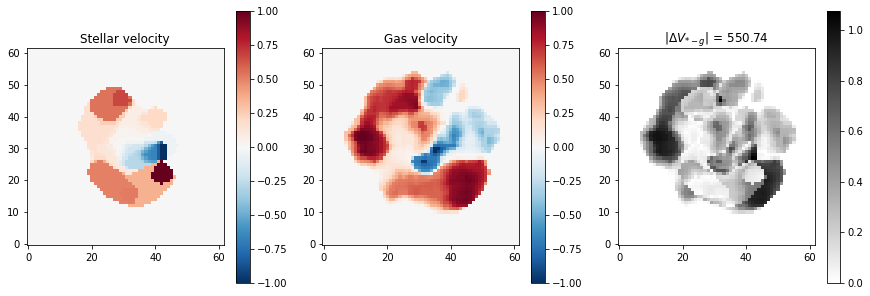

In [45]:
# Plot rows of dataframe as quality control

row = 85

sv = df['Stellar_vel'][row]
gv = df['Gas_vel'][row]
dvsg = df['Delta_V_star_g'][row]
dvsg_sum = df['Delta_V_star_g_sum'][row]
dvsg_n_non_zero = df['Num_non_zero'][row]

# Create figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

num_xy = np.shape(sv)[0]
x = np.arange(num_xy)
y = x

# Plot .value data
sv_pcolormesh = ax[0].pcolormesh(x, y, sv, cmap="RdBu_r")
fig.colorbar(sv_pcolormesh)
ax[0].set_aspect('equal')
ax[0].set_title("Stellar velocity")
gv_pcolormesh = ax[1].pcolormesh(x, y, gv, cmap="RdBu_r")
fig.colorbar(gv_pcolormesh)
ax[1].set_aspect('equal')
ax[1].set_title("Gas velocity")
dvsg_pcolormesh = ax[2].pcolormesh(x, y, dvsg, cmap=cm.binary)
fig.colorbar(dvsg_pcolormesh)
ax[2].set_aspect('equal')
ax[2].set_title(r"$|\Delta V_{*-g}|$ = " + "{:.2f}".format(dvsg_sum));

### Plot histogram of $\frac{|\Delta V_{*-g}|}{N_{non-zero}}$ (normalised)

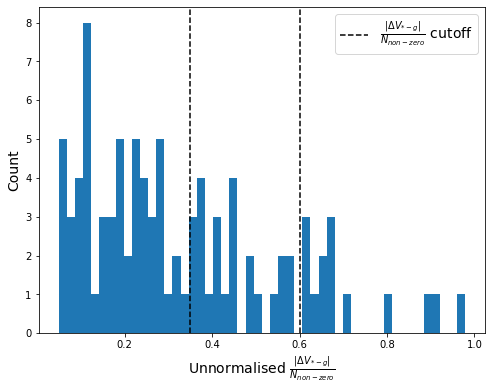

In [39]:
# Weight DVSG sum by number of non-zero spaxels
dvsg_sum_by_n_non_zero = df['Delta_V_star_g_sum'] / df['Num_non_zero']

plt.figure(1, figsize=(8, 6))
plt.hist(dvsg_sum_by_n_non_zero, bins=50);
plt.xlabel(r"Unnormalised $\frac{|\Delta V_{*-g}|}{N_{non-zero}}$", fontsize=14)
plt.ylabel("Count", fontsize=14);
plt.axvline(x=0.35, color="k", linestyle='--')
plt.axvline(x=0.6, color="k", linestyle="--", label=r"$\frac{|\Delta V_{*-g}|}{N_{non-zero}}$ cutoff");
plt.legend(fontsize=14);

plt.savefig("DVSG_by_n_non_zero_hist.jpg")